In [1]:
import ee
import os
import wxee as wx
# Set the path to the service account key file
service_account = 'editor@ee-manmeet20singh15-wbis.iam.gserviceaccount.com'
key_file = '/mnt/kaggle/ndui/ee-manmeet20singh15-wbis-fab7f1ca35e0.json'

# Use the service account for authentication
credentials = ee.ServiceAccountCredentials(service_account, key_file)
# ee.Initialize(credentials)

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com', credentials=credentials)

In [2]:
aoi = ee.Geometry.Polygon(
        [[[-97.7-0.1, 30.2672-0.1],
          [-97.7+0.1, 30.2672-0.1],
          [-97.7+0.1, 30.2672+0.1],
          [-97.7-0.1, 30.2672+0.1]
          ]]
)

In [ ]:
import calendar
start_year = 2015
end_year = 2023

for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        try:
            start_date = f'{year}-{month:02d}-01'
            end_date = f'{year}-{month:02d}-{calendar.monthrange(year, month)[1]}'
            print(start_date, end_date, type(start_date), type(end_date))
            dataset = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')\
                        .filter(ee.Filter.date(start_date, end_date))\
                        .filterBounds(aoi)\
                        .select('VH')

                    ee.ImageCollection('COPERNICUS/S1_GRD')
                        .filterDate(start_date, end_date)
                        .filter(ee.Filter.eq('instrumentMode', 'IW'))
                        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) 
                        .select('VV','VH','angle')
                        .sort('system:time_start', False)
                        .filterBounds(extent)

            ds_dynamic_world = dataset.wx.to_xarray(region=aoi.bounds(), scale=10)
            ds_dynamic_world.vh.to_netcdf(f'dynamic_world_s1_vh_{year}_{month:02d}.nc')

            print(f'Done with {year}-{month:02d}')
        except:
            continue

In [14]:

dataset = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterDate(ee.Date('2016-08-15'), ee.Date('2016-08-30'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
    .filterBounds(aoi)\
    .select('VV')

In [15]:
ds_dynamic_world_water = dataset.wx.to_xarray(region=aoi.bounds(), scale=10)

Requesting data:   0%|          | 0/2 [00:00<?, ?it/s]

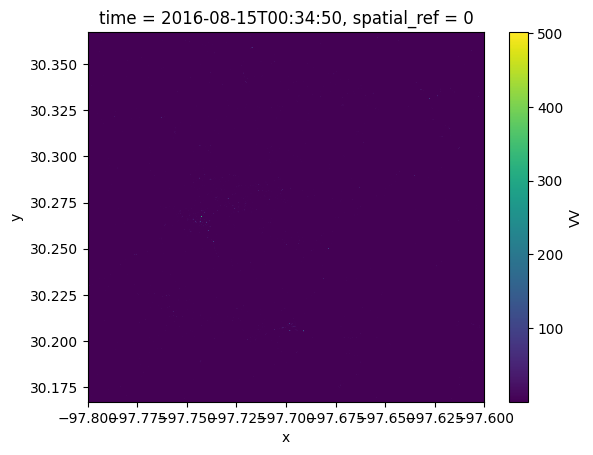

In [35]:
import numpy as np
vv = np.power(10,ds_dynamic_world_water.isel(time=0).VV/10)
vv.plot()

In [18]:

dataset = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterDate(ee.Date('2016-08-15'), ee.Date('2016-08-30'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
    .filterBounds(aoi)\
    .select('VH')
ds_dynamic_world_vh = dataset.wx.to_xarray(region=aoi.bounds(), scale=10)

Requesting data:   0%|          | 0/2 [00:00<?, ?it/s]

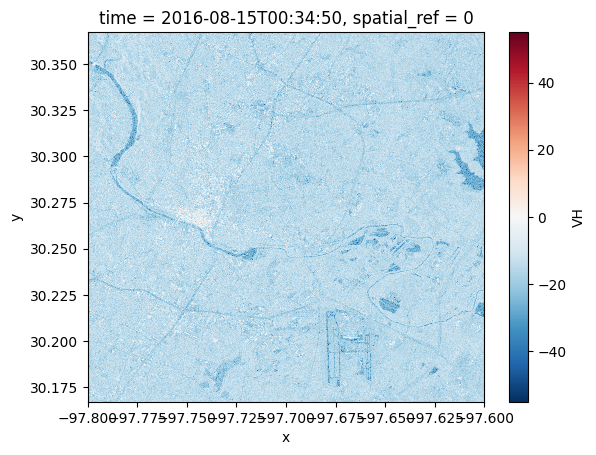

In [22]:
ds_dynamic_world_vh.VH.isel(time=0).plot()

In [27]:
ds_dynamic_world_vh['q'] = 10**(ds_dynamic_world_vh.VH/10) / (10**(ds_dynamic_world_water.VV/10))

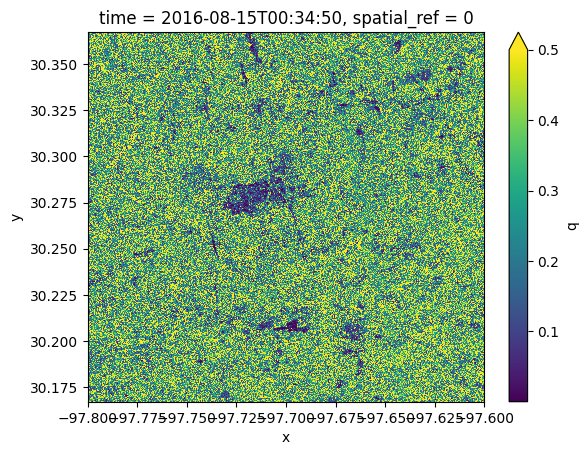

In [38]:
ds_dynamic_world_vh['q'].isel(time=0).plot(vmax=0.5)

# Remove the months which have more than 10 months of water

In [51]:
dataset = ee.Image('JRC/GSW1_2/GlobalSurfaceWater')\
    .select('seasonality').set("system:time_start", ee.Date("2000"))
ds_seasonality = dataset.wx.to_xarray(region=aoi.bounds(), scale=10)

Downloading:   0%|          | 0.00/33.8k [00:00<?, ?iB/s]

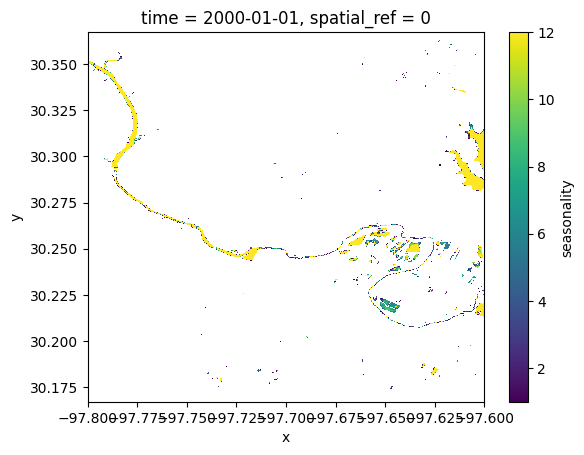

In [52]:
ds_seasonality.seasonality.plot()

In [59]:
ds_seasonality.seasonality.to_dataset().to_netcdf('jrc_seasonality.nc')

# Remove areas with more than 5% slope

In [57]:
dataset = ee.Image('WWF/HydroSHEDS/03CONDEM').select('b1').set("system:time_start", ee.Date("2000"))
ds_elevation = dataset.wx.to_xarray(region=aoi.bounds(), scale=10)
ds_elevtion

Downloading:   0%|          | 0.00/128k [00:00<?, ?iB/s]

NameError: name 'ds_elevtion' is not defined

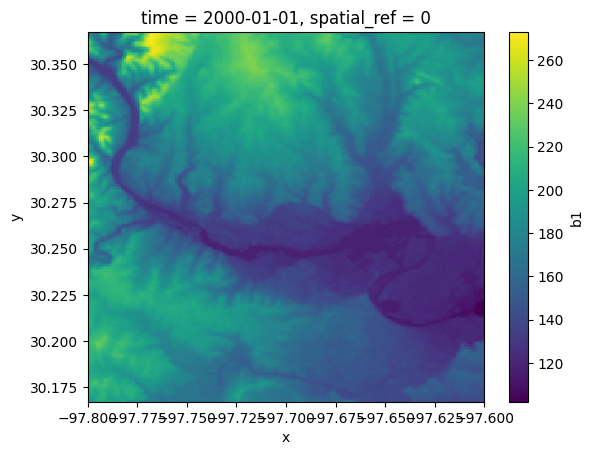

In [ ]:
ds_elevation.b1.plot()

In [58]:
# Calculate the gradients
elevation_array = ds_elevation['b1'].values
gradient_x, gradient_y = np.gradient(elevation_array)

# Calculate the slope
slope = np.sqrt(gradient_x**2 + gradient_y**2)

# Plot the slope
plt.figure(figsize=(10, 8))
plt.imshow(slope, cmap='terrain')
plt.colorbar(label='Slope')
plt.title('Slope Map')
plt.show()

# Find the slope as a number between 0 to 100
slope_percentage = (slope - slope.min()) / (slope.max() - slope.min()) * 100
average_slope = np.mean(slope_percentage)
print(f'Average slope (0-100 scale): {average_slope:.2f}')

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.